In [278]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

## data_import

In [296]:
file_path = r'C:\Users\Surya Teja\OneDrive - Ultraviolette Automotive Private Limited\UV\Testing\Drive_cycle_derivation\Code\VBN_10\generated_WMTC_DC\comb_itr2.xlsx'

In [297]:
df_dc = pd.read_excel(file_path,sheet_name='itr2_avg')

In [298]:
# df_dc = round(df_dc,0)

In [299]:
# df_dc = pd.read_csv(r'C:\Users\Surya Teja\OneDrive - Ultraviolette Automotive Private Limited\UV\Testing\Drive_cycle_derivation\Code\VBN_10\output_4EBEOhO_22122022_101334\speed_out.csv')
# time = df_dc['time_s']
# speed = df_dc['speed_kmph']

In [300]:
time = df_dc['time_s']
speed = df_dc['avg_speed_kmph']

In [301]:
vehicle_param = {'mass': 285,
                 'a' : 35, #N from caostdown
                 'c' : 0.0251 #N/(km/hr)^2
                 }

In [302]:
diff = [((speed[i+1]-speed[i-1])/3.6)/(time[i+1]-time[i-1]) for i in np.arange(1,len(time)-1)]
accn_mps2 = np.insert(diff,0,0)
accn_mps2 = np.append(accn_mps2,0)

## Functions

### SAFD

In [303]:
def safd_matrix(speed,accn_mps2,size):

    #bins
    bins_speed = np.round(np.arange(0,np.ceil(speed.max())+10,10).tolist(),2)
    bins_accn = np.round(np.arange(np.ceil(accn_mps2.min()*10)/10-0.1,np.ceil(accn_mps2.max()*10)/10+0.1,0.1).tolist(),2)

    speed_states = np.digitize(speed, bins_speed) - 1
    accn_states = np.digitize(accn_mps2, bins_accn) - 1

    df_states = pd.DataFrame()
    df_states['speed_states'] = speed_states
    df_states['accn_states'] = accn_states

    safd_matrix = np.zeros([len(bins_accn),len(bins_speed)])

    speed_lable = []
    for t in np.arange(len(bins_speed)-1):
        speed_lable.append(str(bins_speed[t])+'-'+str(bins_speed[t+1]))

    accn_lable = []
    for t in np.arange(len(bins_accn)-1):
        accn_lable.append(str(bins_accn[t])+'-'+str(bins_accn[t+1]))

    for i in range(len(bins_accn)):
        j = 0
        for j in range(len(bins_speed)):
            safd_matrix[i,j] = len(df_states[(df_states['speed_states'] == j)&(df_states['accn_states'] == i)])

    df_safd_matrix = pd.DataFrame(safd_matrix)
    df_safd_matrix.drop(df_safd_matrix.index[-1], inplace=True)
    df_safd_matrix.drop(df_safd_matrix.columns[-1], axis=1, inplace=True)

    fig,ax = plt.subplots(figsize=size)
    # heatmap = ax.imshow(df_safd_matrix.values, cmap = 'viridis',aspect='auto')
    heatmap = ax.imshow(df_safd_matrix.values, cmap = 'viridis',aspect='auto', vmax=500)
    ax.set_xticks(np.arange(len(speed_lable)))
    ax.set_yticks(np.arange(len(accn_lable)))
    ax.set_xticklabels(speed_lable)
    ax.set_yticklabels(accn_lable)
    for i in range(len(accn_lable)):
        for j in range(len(speed_lable)):
            text = ax.text(j, i, '{:.0f}'.format(safd_matrix[i, j]),
                        ha="center", va="center", color="w")

    cbar = plt.colorbar(heatmap)
    return df_safd_matrix

### power and energy

In [304]:
def energy_calc(time,speed,accn_mps2,vehicle_param):
    df_energy = pd.DataFrame()
    df_energy['time_s'] = time
    df_energy['speed_kmph'] = speed
    df_energy['accn_mps2'] = accn_mps2
    df_energy['dist_km'] = ((((df_energy['speed_kmph'].add(df_energy['speed_kmph'].shift(1)))/(2*3600))*(df_energy['time_s'] .sub(df_energy['time_s'] .shift(1)))).fillna(0)).cumsum()

    df_energy['Fr'] = vehicle_param['a'] + vehicle_param['c']*pow(df_energy['speed_kmph'],2) # a+cv^2 in N and v in kmph
    df_energy['Fa'] = vehicle_param['mass']*df_energy['accn_mps2'] # ma in N
    df_energy['Ft'] = df_energy['Fa'] + df_energy['Fr'] # total tractive effort in N

    # power
    df_energy['pwr_kW'] = (df_energy['Ft'] * df_energy['speed_kmph']/3.6)/1000 

    # energy
    df_energy['energy_Wh'] = ((((df_energy['pwr_kW'].add(df_energy['pwr_kW'].shift(1)))*1000/(2*3600))*(df_energy['time_s'] .sub(df_energy['time_s'] .shift(1)))).fillna(0)).cumsum()

    #Wh/km
    df_energy['Wh/km'] = ((df_energy['energy_Wh'])/df_energy['dist_km']).fillna(0)

    df_energy = df_energy.round(2)

    fig = px.line(df_energy,x = 'time_s',y = df_energy.columns)
    display(fig)
    return df_energy

### Stats

In [305]:
def stats(df_energy):
    stats = {}
    stats['total_time_s'] = df_energy['time_s'].max()
    stats['dist_km'] = df_energy['dist_km'].max()
    stats['max_speed_kmph'] = df_energy['speed_kmph'].max()
    stats['avg_speed_kmph'] = df_energy['speed_kmph'].mean().round(2)
    stats['max_positive_accn_mps2'] = df_energy['accn_mps2'].max()
    stats['max_negative_accn_mps2'] = df_energy['accn_mps2'].min()
    stats['rms_positive_accn_mps2'] = round(np.sqrt(np.mean(df_energy.loc[df_energy['accn_mps2']>0,'accn_mps2'] ** 2)),2)
    stats['rms_negative_accn_mps2'] = round(np.sqrt(np.mean(df_energy.loc[df_energy['accn_mps2']<0,'accn_mps2'] ** 2)),2)
    stats['avg_power_kW'] = df_energy['pwr_kW'].mean().round(2)
    stats['max_power_kW'] = df_energy['pwr_kW'].max()
    stats['total_energy_Wh'] = df_energy['energy_Wh'].iloc[-1]
    stats['Wh/km'] = df_energy['Wh/km'].iloc[-1]
    return stats

## calc

### SAFD

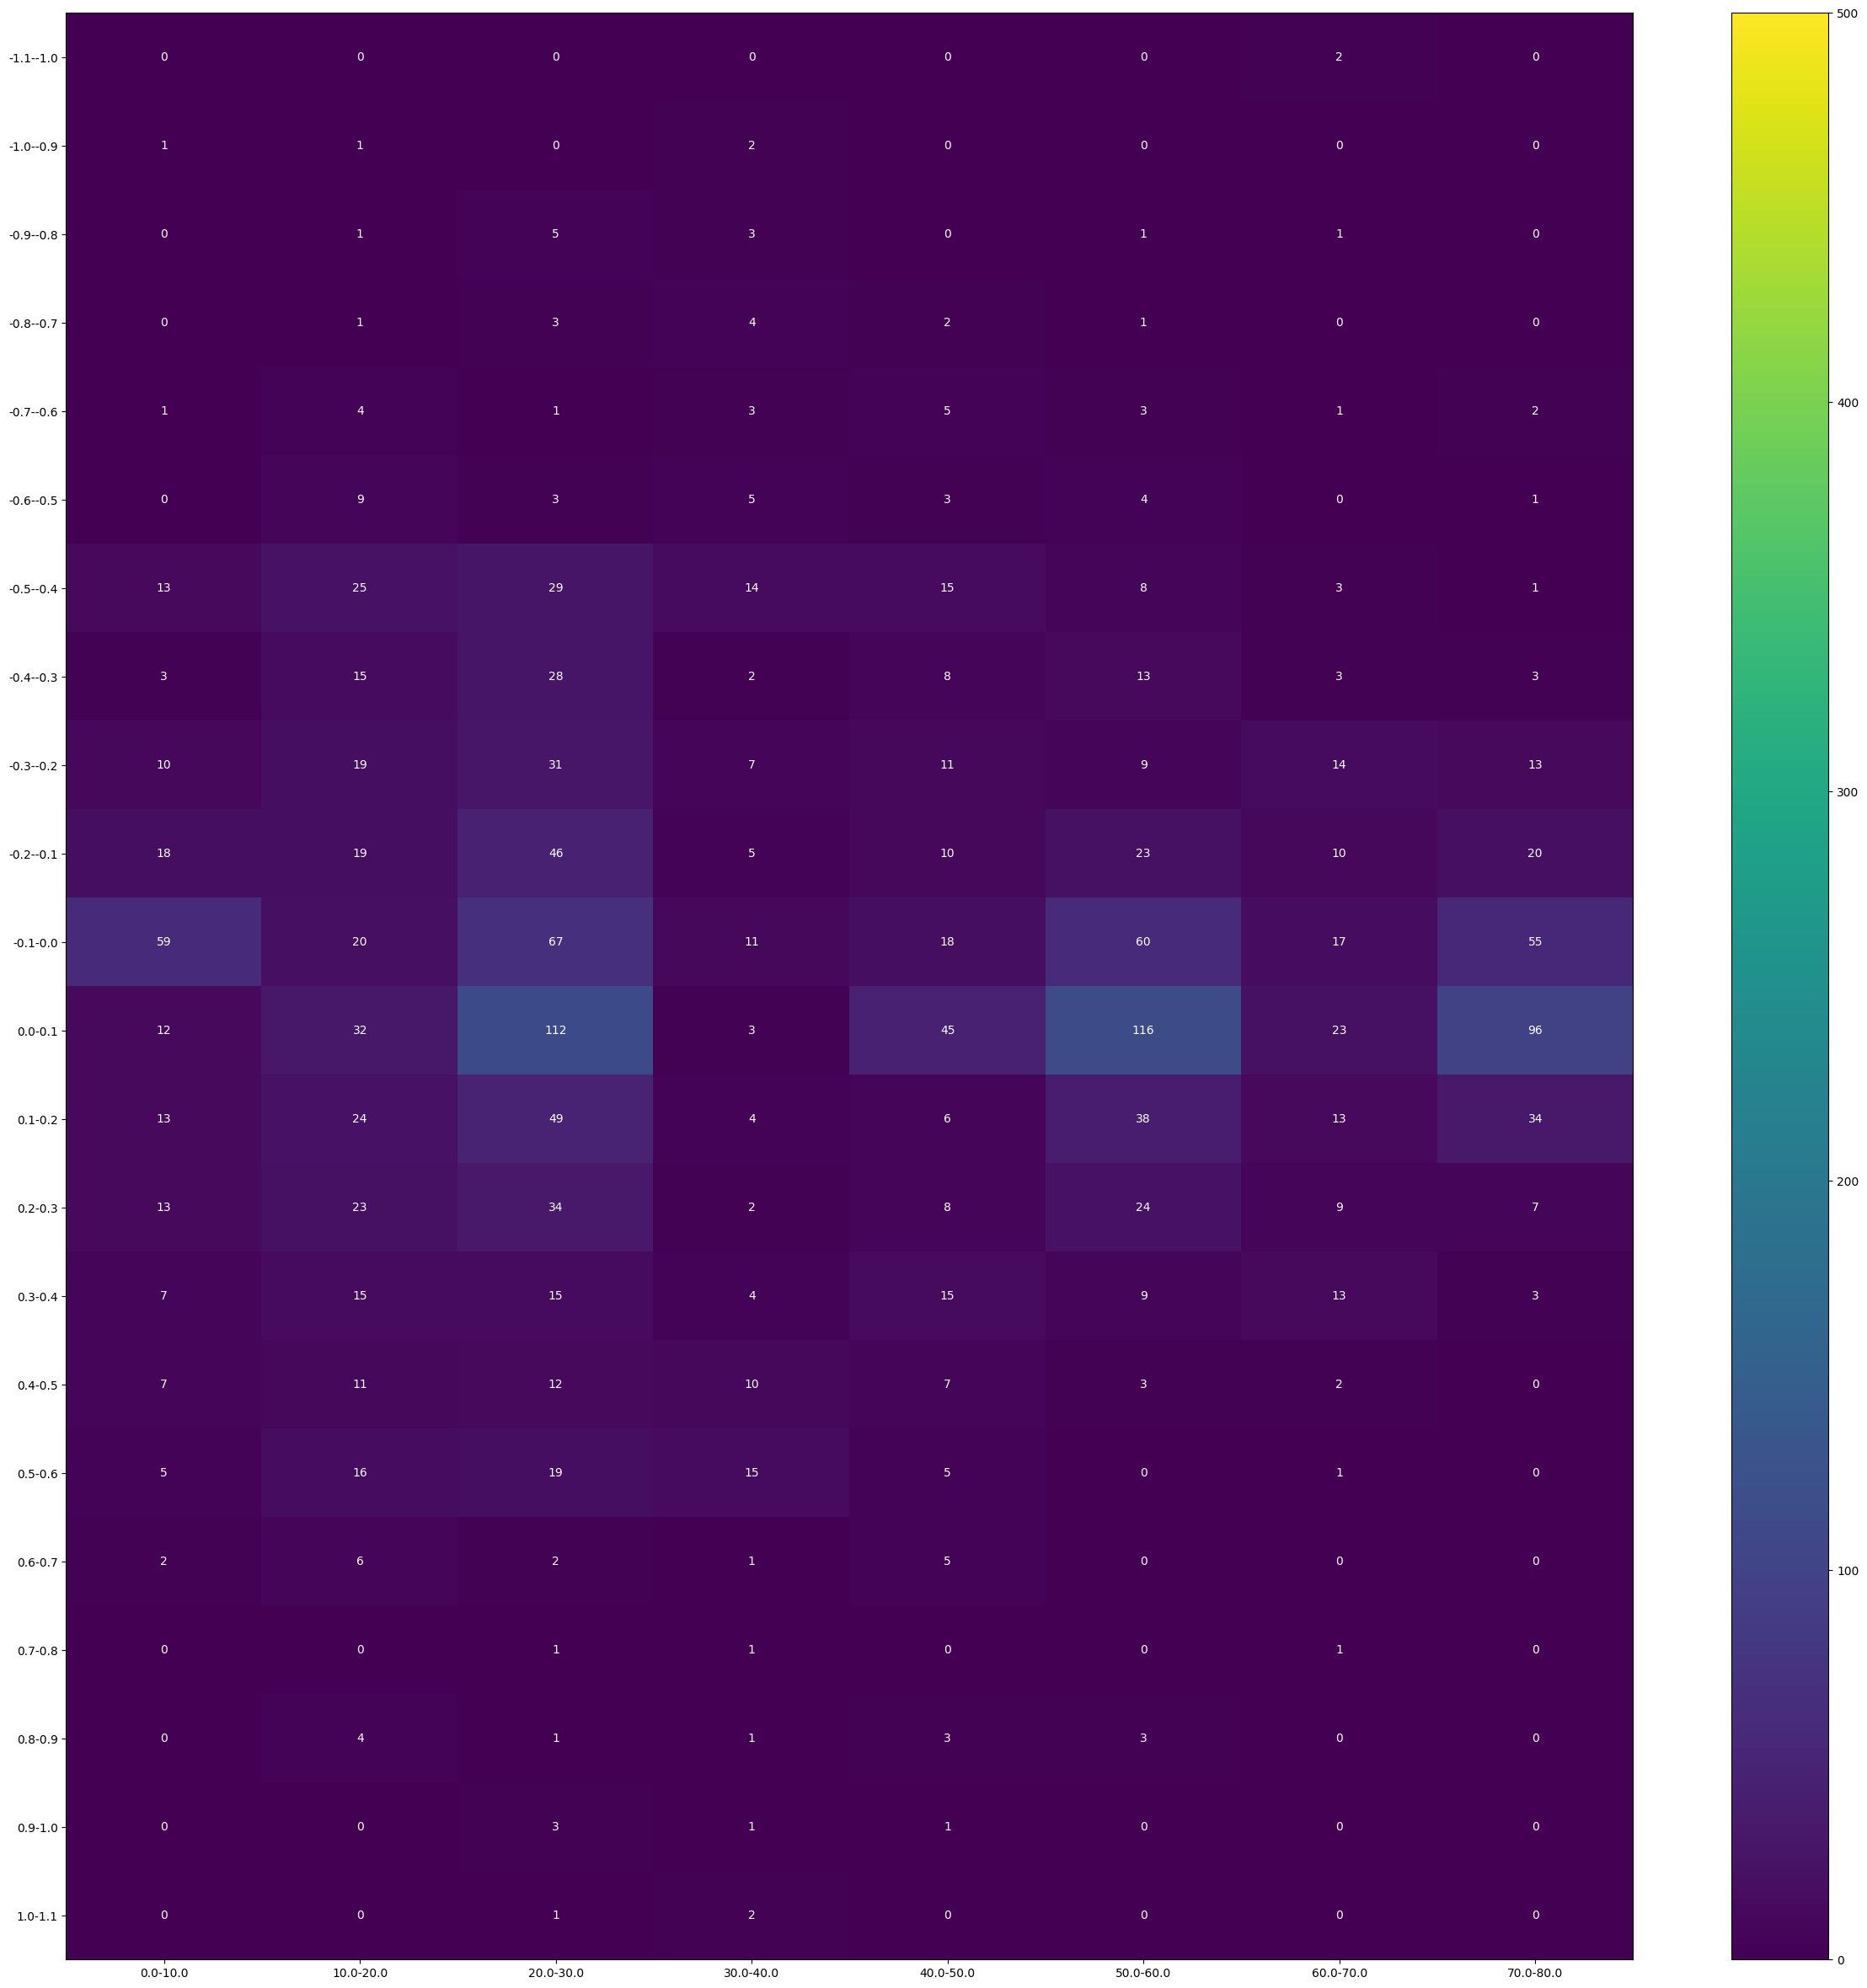

In [306]:
df_safd_matrix = safd_matrix(speed,accn_mps2,[30,30])

### power and energy calc

In [307]:
df_energy = energy_calc(time,speed,accn_mps2,vehicle_param)

### stats

In [308]:
dc_stats = stats(df_energy)
for key in dc_stats:
    print(key, ' : ', dc_stats[key])

total_time_s  :  1800
dist_km  :  19.3
max_speed_kmph  :  77.69
avg_speed_kmph  :  38.59
max_positive_accn_mps2  :  1.07
max_negative_accn_mps2  :  -1.06
rms_positive_accn_mps2  :  0.3
rms_negative_accn_mps2  :  0.31
avg_power_kW  :  1.19
max_power_kW  :  6.12
total_energy_Wh  :  596.93
Wh/km  :  30.92
